This notebook shows how to use the adapter merging methods from `peft` and apply them image generation models using `diffusers`.

## Turn `diffusers` LoRA checkpoints into `PeftModel`

In [ ]:
!pip install diffusers accelerate transformers -U -q
!pip install git+https://github.com/huggingface/peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import userdata
TOKEN = userdata.get("HF_TOKEN")

In [ ]:
from diffusers import UNet2DConditionModel
import torch

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

In [ ]:
# So that we can populate it later.
import copy

sdxl_unet = copy.deepcopy(unet)

In [ ]:
# Load the pipeline too.
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    model_id, variant="fp16", torch_dtype=torch.float16, unet=unet
).to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Only UNet
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

toy_face_sdxl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
from peft import get_peft_model, LoraConfig

toy_peft_model = get_peft_model(
    sdxl_unet,
    pipe.unet.peft_config["toy"],
    adapter_name="toy"
)

In [ ]:
original_state_dict = {f"base_model.model.{k}": v for k, v in pipe.unet.state_dict().items()}

toy_peft_model.load_state_dict(original_state_dict, strict=True)
toy_peft_model.push_to_hub("toy_peft_model-new", token=TOKEN)

README.md:   0%|          | 0.00/5.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sayakpaul/toy_peft_model-new/commit/85a43b6eae5c1634827e0457a45220da8cf17d75', commit_message='Upload model', commit_description='', oid='85a43b6eae5c1634827e0457a45220da8cf17d75', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
pipe.delete_adapters("toy")
sdxl_unet.delete_adapters("toy")

In [ ]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters(adapter_names="pixel")

pixel-art-xl.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
pixel_peft_model = get_peft_model(
    sdxl_unet,
    pipe.unet.peft_config["pixel"],
    adapter_name="pixel"
)

original_state_dict = {f"base_model.model.{k}": v for k, v in pipe.unet.state_dict().items()}
pixel_peft_model.load_state_dict(original_state_dict, strict=True)
pixel_peft_model.push_to_hub("pixel_peft_model-new", token=TOKEN)

adapter_model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sayakpaul/pixel_peft_model-new/commit/02cfa783ac39e0dc8de871298f8d6632ac796b0d', commit_message='Upload model', commit_description='', oid='02cfa783ac39e0dc8de871298f8d6632ac796b0d', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
del pipe, sdxl_unet, toy_peft_model, pixel_peft_model

## Weighted adapter inference

In [ ]:
from peft import PeftModel

base_unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to("cuda")

toy_id = "sayakpaul/toy_peft_model-new"
model = PeftModel.from_pretrained(base_unet, toy_id, use_safetensors=True, subfolder="toy", adapter_name="toy")
model.load_adapter("sayakpaul/pixel_peft_model-new", use_safetensors=True, subfolder="pixel", adapter_name="pixel")

# https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.add_weighted_adapter
model.add_weighted_adapter(
    adapters=["toy", "pixel"],
    weights=[0.7, 0.3],
    combination_type="linear",
    adapter_name="toy-pixel"
)
model.set_adapters("toy-pixel")

toy/adapter_config.json:   0%|          | 0.00/47.3k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

pixel/adapter_config.json:   0%|          | 0.00/47.3k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
type(model.base_model.model)

diffusers.models.unets.unet_2d_condition.UNet2DConditionModel

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

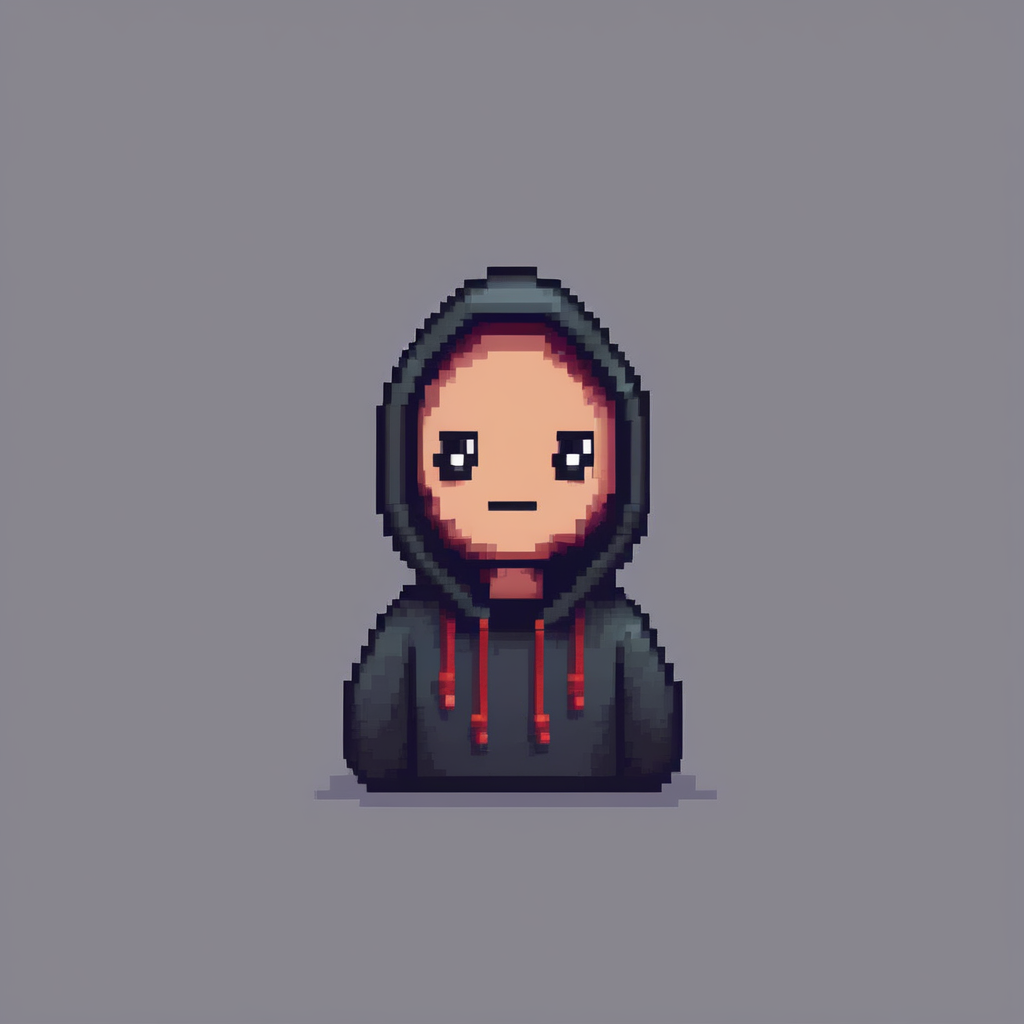

In [ ]:
model = model.to(dtype=torch.float16, device="cuda")

pipe = DiffusionPipeline.from_pretrained(
    model_id, unet=model, variant="fp16", torch_dtype=torch.float16,
).to("cuda")

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

In [ ]:
del pipe

In [ ]:
base_unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to("cuda")

toy_id = "sayakpaul/toy_peft_model-new"
model = PeftModel.from_pretrained(base_unet, toy_id, use_safetensors=True, subfolder="toy", adapter_name="toy")
model.load_adapter("sayakpaul/pixel_peft_model-new", use_safetensors=True, subfolder="pixel", adapter_name="pixel")

# https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.add_weighted_adapter
model.add_weighted_adapter(
    adapters=["toy", "pixel"],
    weights=[0.5, 0.5],
    combination_type="cat",
    adapter_name="toy-pixel"
)
model.set_adapters("toy-pixel")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

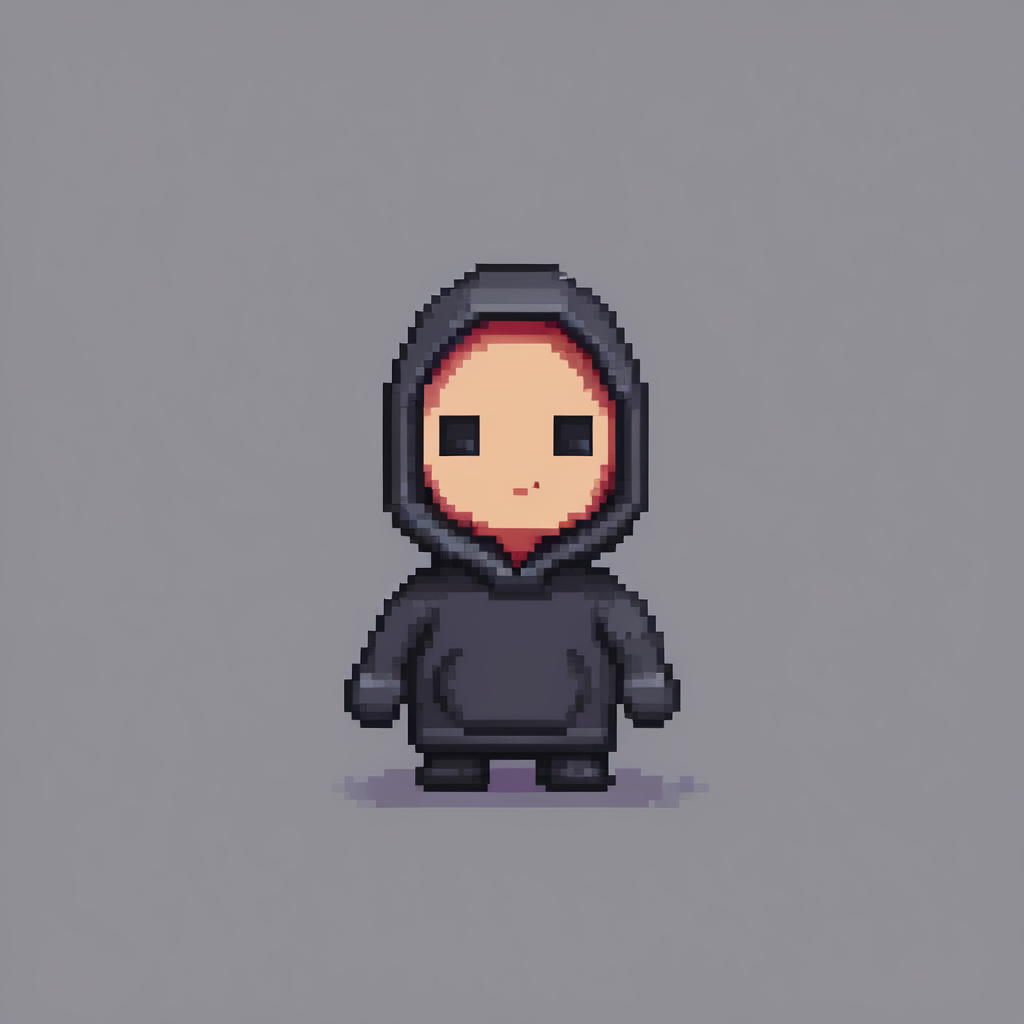

In [ ]:
model = model.to(dtype=torch.float16, device="cuda")

pipe = DiffusionPipeline.from_pretrained(
   model_id, unet=model, variant="fp16", torch_dtype=torch.float16,
).to("cuda")

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

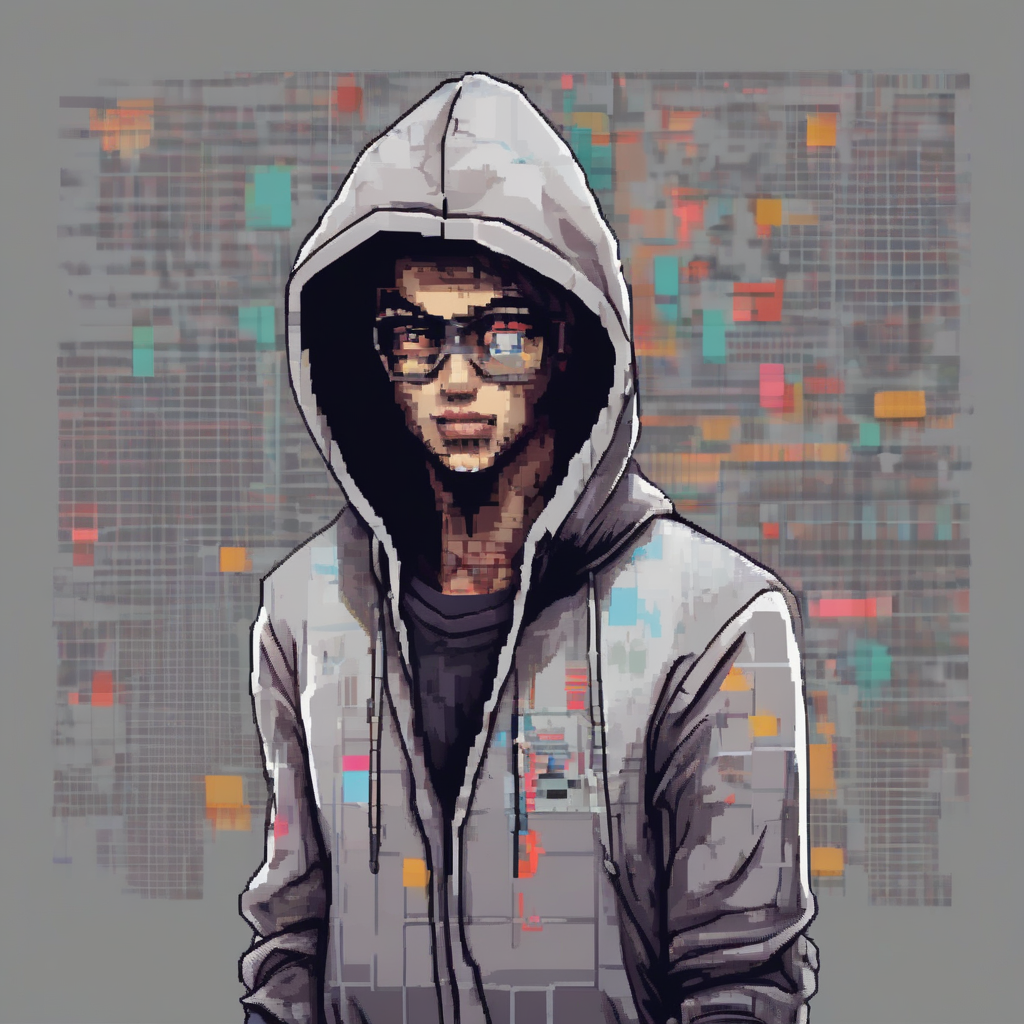

In [ ]:
del pipe

pipe = DiffusionPipeline.from_pretrained(
    model_id, variant="fp16", torch_dtype=torch.float16,
).to("cuda")

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image